# Import libraries

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Load data and split into train set and test set

In [53]:
price_df = pd.read_csv("./Housing.csv")[['price']]
price_df['price'] = price_df['price'].div(100000)
price_df.head()

,price
0,133.00
1,122.50
2,122.50
3,122.15
4,114.10


In [54]:
# split into train set and test set
train, test = price_df[0:int(len(price_df)*0.8)], price_df[int(len(price_df)*0.8):]

In [55]:
len(train), len(test)

(436, 109)

# 1. Univariate Time-series prediction via Neural Network in ```TensorFlow```

In [56]:
from keras.models import Sequential
from keras.layers import Dense

In [57]:
# data pre-processing
# How many previous price will be used to predict the next day price
def X2Xy(X_arr, window):
    X, Y = [], []
    for i in range(len(X_arr) - window):
        X.append(X_arr[i:i+window])
        Y.append(X_arr[i+window])
    return np.array(X), np.array(Y)

In [58]:
trainX, trainY = X2Xy(train['price'].values, window=10)
testX, testY = X2Xy(test['price'].values, window=10)

In [59]:
trainX.shape, trainY.shape

((426, 10), (426,))

In [60]:
# NN model
model=Sequential()
model.add(Dense(units=1, input_dim=10, activation='relu')) # input_dim is the dim of 1-D X
model.add(Dense(8, activation='relu'))
model.add(Dense(1)) # = dim of y
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

history=model.fit(trainX,trainY, epochs=50, validation_data=(testX,testY),
                  shuffle=False)

Train on 426 samples, validate on 99 samples
Epoch 1/50
426/426 [==============================] - 0s 450us/step - loss: 164.3536 - mse: 164.3537 - mae: 11.7225 - val_loss: 12.8071 - val_mse: 12.8071 - val_mae: 3.4229
Epoch 2/50
426/426 [==============================] - 0s 140us/step - loss: 29.4136 - mse: 29.4136 - mae: 4.7003 - val_loss: 0.5380 - val_mse: 0.5380 - val_mae: 0.6190
Epoch 3/50
426/426 [==============================] - 0s 133us/step - loss: 1.2120 - mse: 1.2120 - mae: 0.5670 - val_loss: 1.2406 - val_mse: 1.2406 - val_mae: 0.9650
Epoch 4/50
426/426 [==============================] - ETA: 0s - loss: 40.0564 - mse: 40.0564 - mae: 5.153 - 0s 137us/step - loss: 3.8152 - mse: 3.8152 - mae: 1.0021 - val_loss: 0.7155 - val_mse: 0.7155 - val_mae: 0.6055
Epoch 5/50
426/426 [==============================] - 0s 130us/step - loss: 2.4751 - mse: 2.4751 - mae: 0.7475 - val_loss: 0.4308 - val_mse: 0.4308 - val_mae: 0.4503
Epoch 6/50
426/426 [==============================] - 0s 182us

426/426 [==============================] - 0s 123us/step - loss: 1.8541 - mse: 1.8541 - mae: 0.7384 - val_loss: 0.5785 - val_mse: 0.5785 - val_mae: 0.4951
Epoch 50/50
426/426 [==============================] - 0s 129us/step - loss: 1.8511 - mse: 1.8511 - mae: 0.7375 - val_loss: 0.5824 - val_mse: 0.5824 - val_mae: 0.4975


Train Root Mean Squared Error(RMSE): 1.28; Train Mean Absolute Error(MAE) : 0.53 
Test Root Mean Squared Error(RMSE): 0.76; Test Mean Absolute Error(MAE) : 0.50 


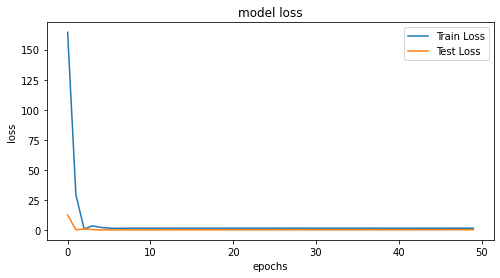

In [61]:
# model measurement
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()

train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

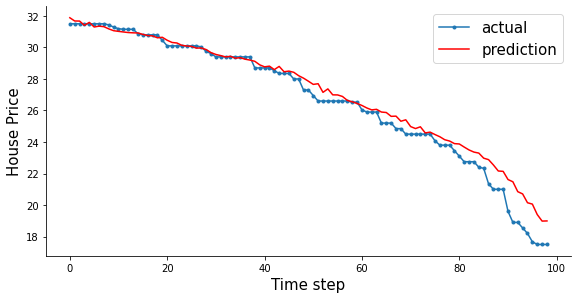

In [62]:
# prediction visualization
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('House Price', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()
    
test_predict= model.predict(testX)
prediction_plot(testY, test_predict)

# 2. Univariate Time-series prediction via Autoregressive integrated moving average (ARIMA) in ```statsmodels```

In [63]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [94]:
train_ar = train['price'].values
test_ar = test['price'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_ar, predictions))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 0.28


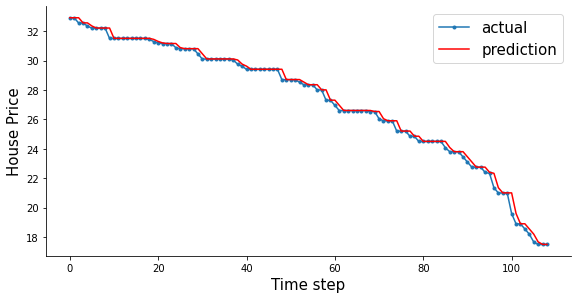

In [95]:
prediction_plot(test_ar, predictions)

# 3. Combining these two models into one using the inverse-variance weighting method.

It is to give more weight to the model with lower error

$$w_i=\frac{e_{i}^{-1}}{\sum_{}{{e_{i}^{-1}}}}$$

In [96]:
w_nn = (1/0.76) / ((1/0.76) + (1/0.25))
w_arima = (1/0.25) / ((1/0.76) + (1/0.25))

In [97]:
w_nn, w_arima

(0.24752475247524755, 0.7524752475247525)

In [98]:
combined_predict = []
for i in range(len(test_predict)):
    new_predict = w_nn*test_predict[i] + w_arima*predictions[i]
    combined_predict.append(new_predict)

In [102]:
rmse = sqrt(mean_squared_error(test_ar[:99], combined_predict))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 0.23


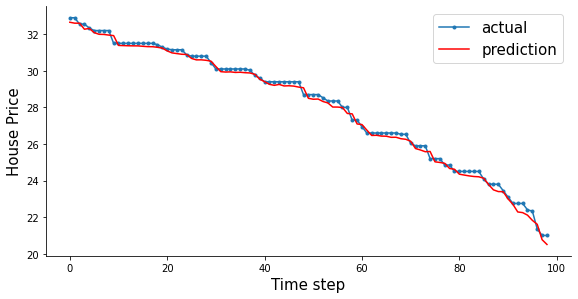

In [103]:
prediction_plot(test_ar[:99], combined_predict)

# 4. Compare three methods

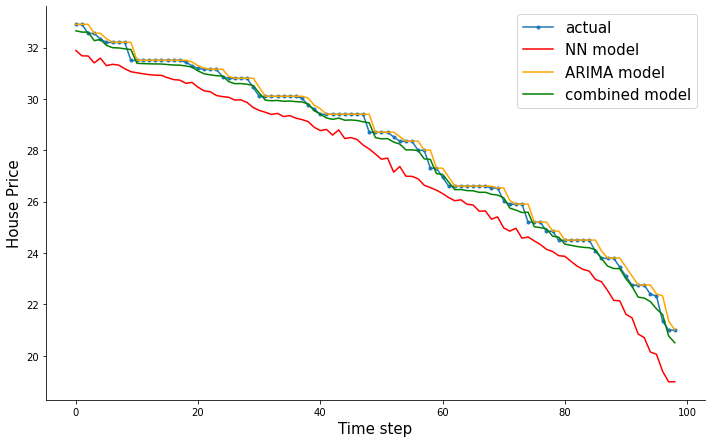

In [108]:
len_prediction=[x for x in range(len(test_ar[:99]))]
plt.figure(figsize=(10,6))
plt.plot(len_prediction, test_ar[:99], marker='.', label="actual")
plt.plot(len_prediction, test_predict, 'r', label="NN model")
plt.plot(len_prediction, predictions[:99], 'orange', label="ARIMA model")
plt.plot(len_prediction, combined_predict, 'green', label="combined model")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('House Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()